## Overview

### The data has been split into two groups:

training set (train.csv)
test set (test.csv)

- The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

- The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

### Data Dictionary

Variable	--- Definition	Key 

survival	--- Survival	0 = No, 1 = Yes 

pclass	--- Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd 

sex	--- Sex	

Age	--- Age in years	

sibsp	--- # of siblings / spouses aboard the Titanic	

parch	--- # of parents / children aboard the Titanic	

ticket	--- Ticket number	

fare	--- Passenger fare	

cabin	--- Cabin number	

embarked	--- Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable --- Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.m

In [75]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [80]:
testdf = pd.read_csv("./input/test.csv")   # test set
traindf = pd.read_csv("./input/train.csv")
#sampledf = pd.read_csv("./input/gender_submission.csv")

PassengerId = testdf['PassengerId']

In [82]:
traindf.shape

(891, 12)

In [4]:
traindf.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


need parsing : 'Ticket', 'Cabin'

NaN process : 'Age', 'Cabin', 'Embarked'

In [26]:
traindf[traindf.Age.isnull() == True].Pclass.value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

In [6]:
traindf[traindf.Pclass == 1].Parch.value_counts()

0    163
1     31
2     21
4      1
Name: Parch, dtype: int64

In [7]:
traindf[traindf.Pclass == 3].SibSp.value_counts()

0    351
1     83
4     18
2     15
3     12
8      7
5      5
Name: SibSp, dtype: int64

In [8]:
traindf[traindf.Age < 18].Parch.value_counts()

1    44
2    36
0    32
3     1
Name: Parch, dtype: int64

In [9]:
(traindf[traindf.Age <= 15].Parch.value_counts())-(traindf[traindf.Age <= 14].Parch.value_counts())

1    2
2    0
0    4
Name: Parch, dtype: int64

In [10]:
traindf[traindf.Age <= 14].Parch.value_counts()

1    37
2    33
0     7
Name: Parch, dtype: int64

In [11]:
traindf[traindf.Age <= 14].SibSp.value_counts()

1    24
0    20
4    16
3     7
2     6
5     4
Name: SibSp, dtype: int64

In [83]:
# has NaN 

col_n = ['Age', 'Fare', 'Cabin', 'Embarked']
for i in col_n:
    print (i)
    print (traindf[i].isnull().value_counts())
    print()

Age
False    714
True     177
Name: Age, dtype: int64

Fare
False    891
Name: Fare, dtype: int64

Cabin
True     687
False    204
Name: Cabin, dtype: int64

Embarked
False    889
True       2
Name: Embarked, dtype: int64



In [152]:
col_n = ['Age', 'Fare', 'Cabin', 'Embarked']
for i in col_n:
    print (i)
    print (testdf[i].isnull().value_counts())
    print()

Age
False    332
True      86
Name: Age, dtype: int64

Fare
False    417
True       1
Name: Fare, dtype: int64

Cabin
True     327
False     91
Name: Cabin, dtype: int64

Embarked
False    418
Name: Embarked, dtype: int64



In [13]:
cols = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

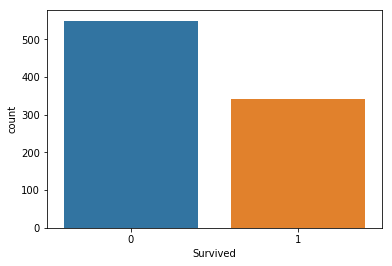

In [14]:
sns.countplot(traindf.Survived)

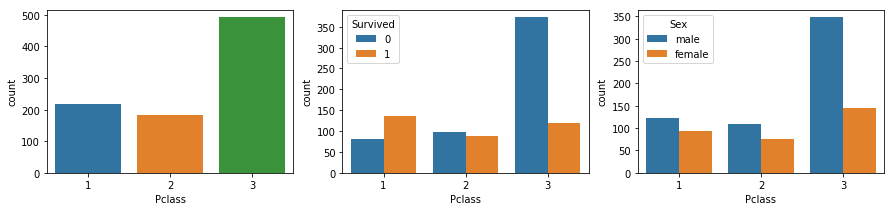

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
sns.countplot(traindf.Pclass, ax=ax1)
sns.countplot(traindf.Pclass, hue=traindf.Survived, ax=ax2)
sns.countplot(traindf.Pclass, hue=traindf.Sex, ax=ax3)

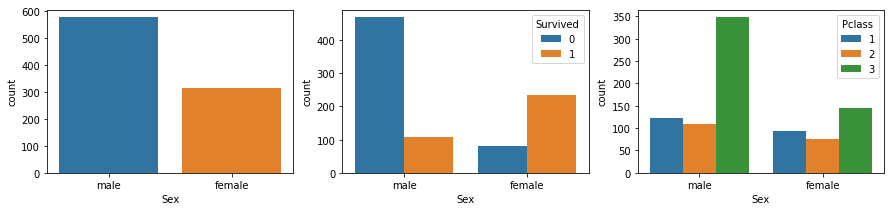

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
sns.countplot(traindf.Sex, ax=ax1)
sns.countplot(traindf.Sex, hue=traindf.Survived, ax=ax2)
sns.countplot(traindf.Sex, hue=traindf.Pclass, ax=ax3)

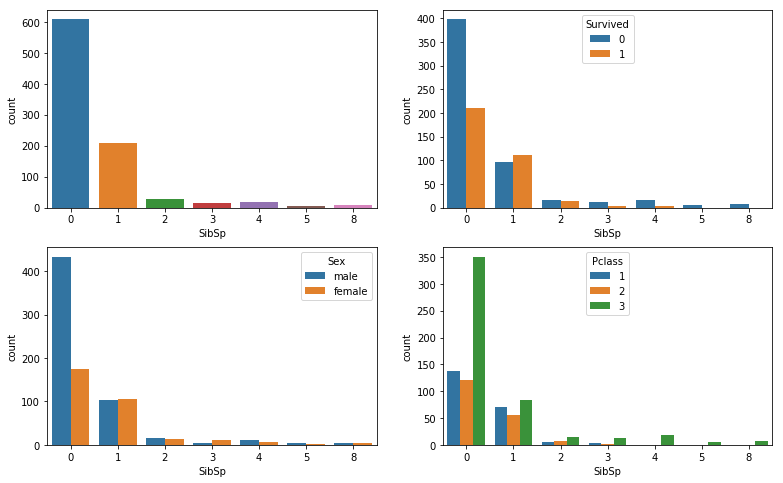

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
sns.countplot(traindf.SibSp, ax=axes[0,0])
sns.countplot(traindf.SibSp, hue=traindf.Survived, ax=axes[0,1])
sns.countplot(traindf.SibSp, hue=traindf.Sex, ax=axes[1,0])
sns.countplot(traindf.SibSp, hue=traindf.Pclass, ax=axes[1,1])

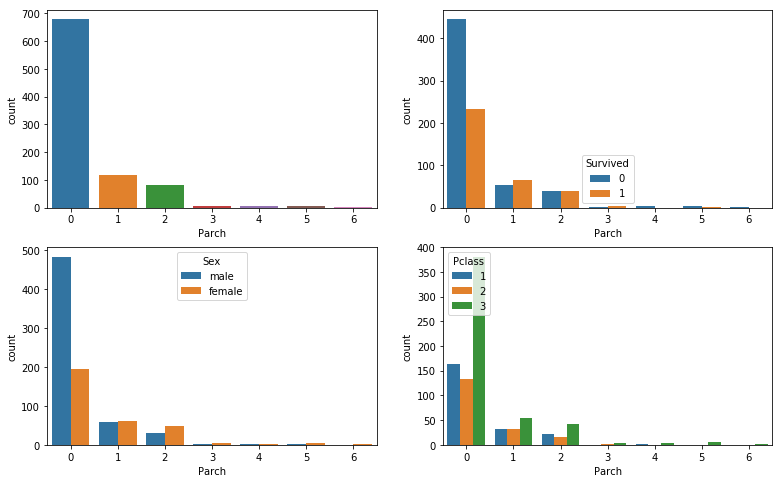

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
sns.countplot(traindf.Parch, ax=axes[0,0])
sns.countplot(traindf.Parch, hue=traindf.Survived, ax=axes[0,1])
sns.countplot(traindf.Parch, hue=traindf.Sex, ax=axes[1,0])
sns.countplot(traindf.Parch, hue=traindf.Pclass, ax=axes[1,1])

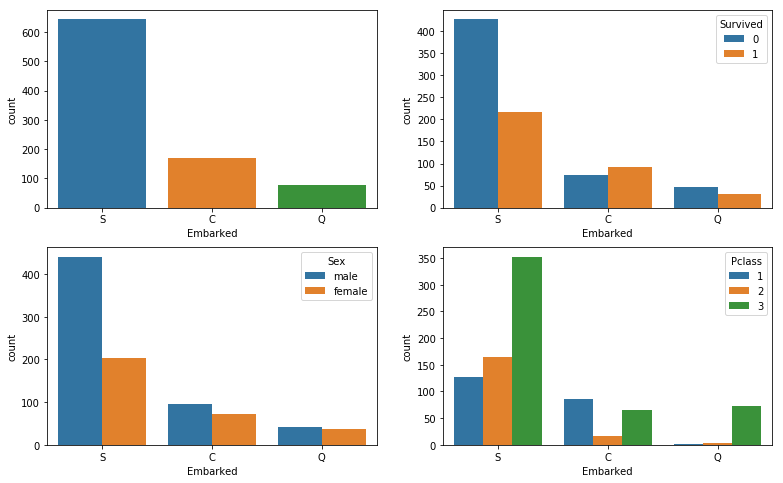

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
sns.countplot(traindf.Embarked, ax=axes[0,0])
sns.countplot(traindf.Embarked, hue=traindf.Survived, ax=axes[0,1])
sns.countplot(traindf.Embarked, hue=traindf.Sex, ax=axes[1,0])
sns.countplot(traindf.Embarked, hue=traindf.Pclass, ax=axes[1,1])

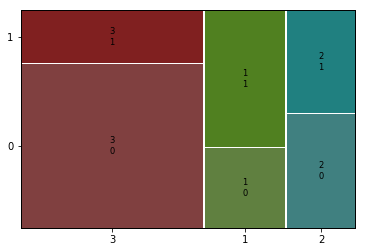

In [20]:
import statsmodels
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10
mosaic = mosaic(traindf, ['Pclass', 'Survived'])

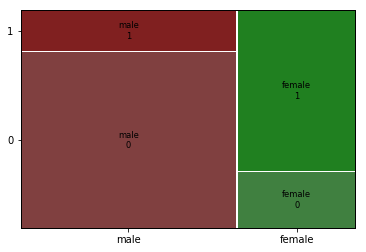

In [21]:
import statsmodels
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10
mosaic = mosaic(traindf, ['Sex', 'Survived'])

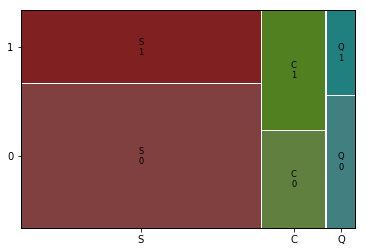

In [22]:
import statsmodels
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10
mosaic = mosaic(traindf, ['Embarked', 'Survived'])

In [84]:
df1 = traindf.copy()

In [149]:
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hadCabin,FamilySize,isAlone,k_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,None
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,None


In [98]:
df1.Cabin[872].find(' ')

3

In [99]:
df1.Cabin[27].find(' ')

3

In [102]:
str(df1.Cabin[0]).find(' ')

-1

In [101]:
df1.Cabin[1].find(' ')

-1

need parsing : 'Ticket', 'Cabin'

NaN process : 'Age', 'Cabin', 'Embarked'

In [41]:
# Age NaN -> median 28.0
df1['Age'] = df1['Age'].replace(np.nan, df1.Age.median())

In [46]:
# Embarked NaN -> most value 'S'
df1['Embarked'] = df1['Embarked'].fillna('S')
#df1['Embarked'] = df1['Embarked'].replace(np.nan, 'S', regex=True)

In [85]:
# Cabin : had cabin or not, divid char & numb

#def had_cabin(x):
#    x = str(x)
#    if x.find('nan') >= 0: return 0
#    return 1

df1['hadCabin'] = df1.Cabin.apply(lambda x: 0 if type(x) == float else 1)

In [142]:
def k_cabin(x):
    x = str(x)
    cabin_search = re.search('([A-L]+)', x)
    if cabin_search:
        return cabin_search.group(1)
    return "None"
df1['k_cabin'] = df1.Cabin.apply(k_cabin)

In [147]:
# [75=G, 128=E, 699=G, 715=G]
df1[df1['k_cabin'] == 'F']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hadCabin,FamilySize,isAlone,n_cabin,k_cabin
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.50,F33,S,1,1,1,0,F
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.00,F2,S,1,3,0,0,F
183,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.00,F4,S,1,4,0,0,F
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.00,F2,S,1,3,0,0,F
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.00,F2,S,1,3,0,0,F
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.00,F33,S,1,1,1,0,F
516,517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.50,F33,S,1,1,1,0,F
618,619,1,2,"Becker, Miss. Marion Louise",female,4.0,2,1,230136,39.00,F4,S,1,4,0,0,F
776,777,0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.75,F38,Q,1,1,1,0,F


In [146]:
df1.k_cabin.iloc[75] = 'G'
df1.k_cabin.iloc[128] = 'E'
df1.k_cabin.iloc[699] = 'G'
df1.k_cabin.iloc[715] = 'G'

C:\Python36\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [87]:
# SibSp + Parch + 1 = FamilySize
df1['FamilySize'] = df1['SibSp']+df1['Parch']+1

In [90]:
# isAlone
df1['isAlone'] = df1.FamilySize.apply(lambda x: 1 if x == 1 else 0)

In [128]:
#df1['sex1'] = df1['Sex'].map({'female':0, 'male':1})

## examples